In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

from PIL import Image
import os

In [2]:
# convert all images to JPG
# Function to convert image format in a directory
def convert_images(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.bmp')):
                try:
                    # Construct the full file path
                    file_path = os.path.join(root, file)

                    # Open the image
                    img = Image.open(file_path)
                    # converting to jpg 
                    rgb_img = img.convert("RGB")

                    # Save the image with the new format
                    new_file_path = os.path.splitext(file_path)[0] + '.jpg'
                    rgb_img.save(new_file_path)

                    # Optional: Remove the original file
                    os.remove(file_path)

                    print(f"Converted: {file}")

                except Exception as e:
                    print(f"Error converting {file}: {e}")

# Specify the directory where your data is located
data_directory = 'data'

# Call the function to convert images in the specified directory
convert_images(data_directory)

total pictures:  1883
card pictures:  80


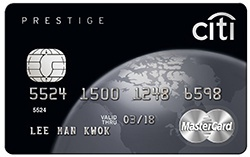

In [3]:
data_dir = pathlib.Path("data/").with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
card_count = len(list(data_dir.glob('debit-card/*.jpg')))
print('total pictures: ', image_count)
print('card pictures: ', card_count)
cards = list(data_dir.glob('debit-card/*.jpg'))
PIL.Image.open(str(cards[0]))

In [4]:
# Use Kearas to build a dataset
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1883 files belonging to 2 classes.
Using 1507 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1883 files belonging to 2 classes.
Using 376 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['debit-card', 'something']


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

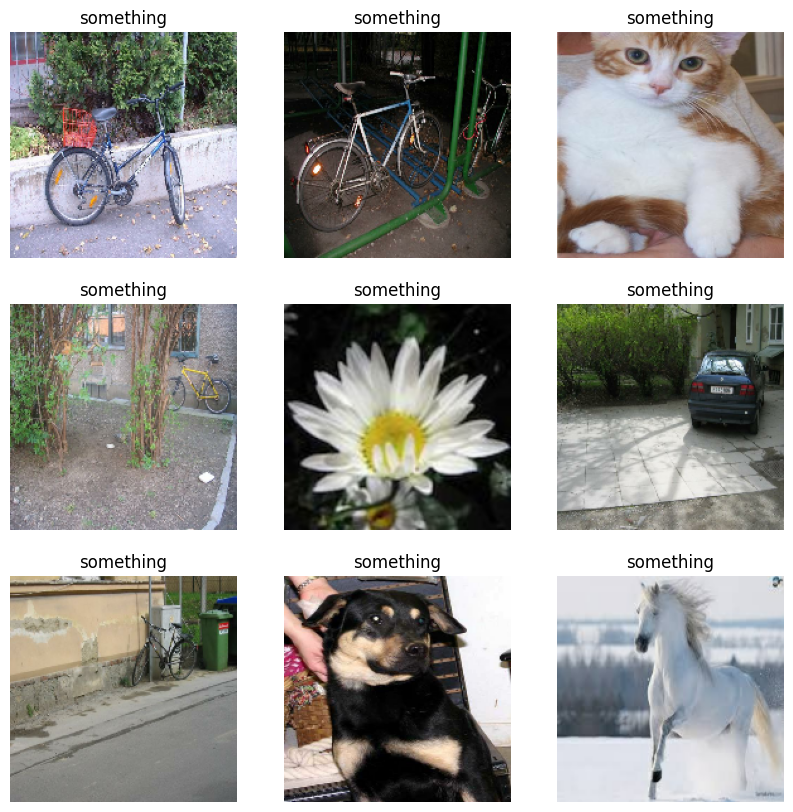

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#rescale the pixles from 0-255 to 0-1
# we will include this layer directly on the layer insead of the data
normalization_layer = layers.Rescaling(1./255)

In [10]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [11]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
48/48 [==============================] - 6s 105ms/step - loss: 0.2236 - accuracy: 0.9376 - val_loss: 0.1807 - val_accuracy: 0.9574
Epoch 2/10
48/48 [==============================] - 5s 103ms/step - loss: 0.1492 - accuracy: 0.9648 - val_loss: 0.1339 - val_accuracy: 0.9601
Epoch 3/10
48/48 [==============================] - 5s 105ms/step - loss: 0.0894 - accuracy: 0.9768 - val_loss: 0.0929 - val_accuracy: 0.9787
Epoch 4/10
48/48 [==============================] - 5s 104ms/step - loss: 0.0610 - accuracy: 0.9827 - val_loss: 0.0646 - val_accuracy: 0.9840
Epoch 5/10
48/48 [==============================] - 5s 105ms/step - loss: 0.0272 - accuracy: 0.9920 - val_loss: 0.0494 - val_accuracy: 0.9920
Epoch 6/10
48/48 [==============================] - 5s 106ms/step - loss: 0.0151 - accuracy: 0.9967 - val_loss: 0.0368 - val_accuracy: 0.9920
Epoch 7/10
48/48 [==============================] - 5s 106ms/step - loss: 0.0099 - accuracy: 0.9960 - val_loss: 0.0498 - val_accuracy: 0.9894
Epoch 

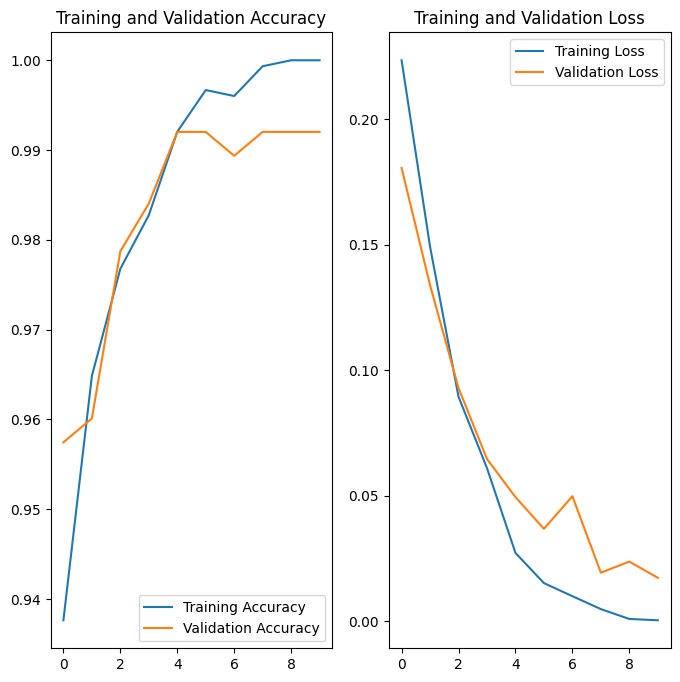

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/10
48/48 [==============================] - 8s 149ms/step - loss: 0.2050 - accuracy: 0.9177 - val_loss: 0.0802 - val_accuracy: 0.9787
Epoch 2/10
48/48 [==============================] - 7s 139ms/step - loss: 0.0529 - accuracy: 0.9874 - val_loss: 0.0268 - val_accuracy: 1.0000
Epoch 3/10
48/48 [==============================] - 7s 142ms/step - loss: 0.0206 - accuracy: 0.9987 - val_loss: 0.0148 - val_accuracy: 1.0000
Epoch 4/10
48/48 [==============================] - 7s 138ms/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 5/10
48/48 [==============================] - 7s 143ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 6/10
48/48 [==============================] - 7s 144ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 7/10
48/48 [==============================] - 7s 138ms/step - loss: 0.0045 - ac

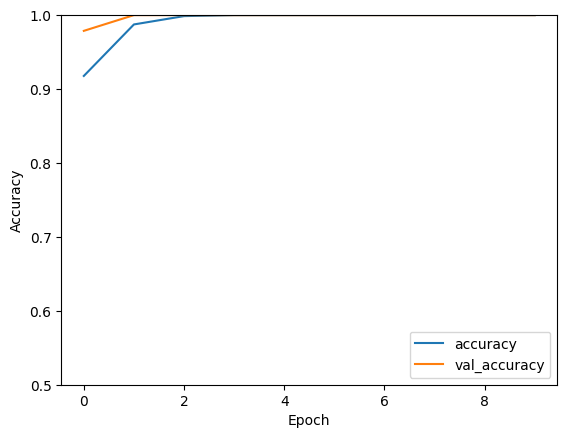

In [13]:
from tensorflow.keras.applications import MobileNetV2

# Load the pre-trained model
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
base_model = MobileNetV2(input_shape=(180, 180, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(180, 180, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1)(x)  # Binary classification
model = tf.keras.Model(inputs, x)

# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=10)


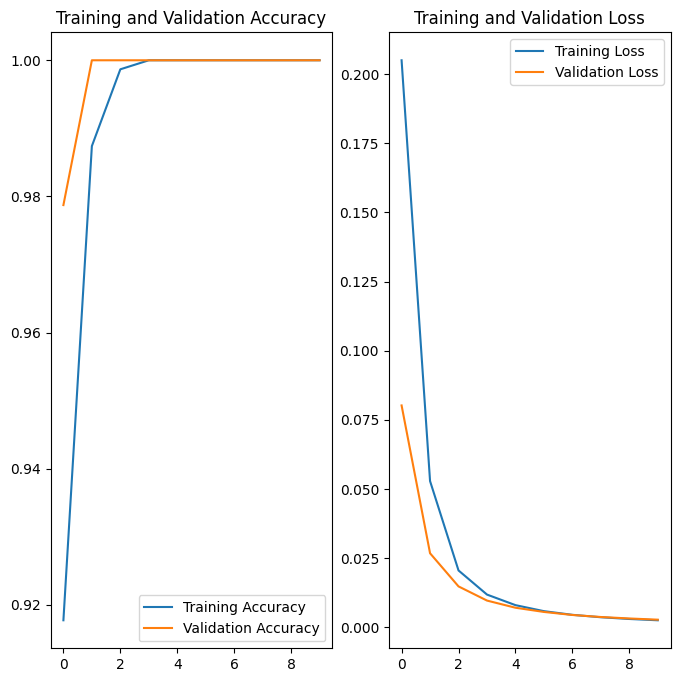

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()